# Galaxy morphology from rest-frame colours

In this task you will use machine learning in Python to assign morphological classes to galaxies. We will do this by constructing the appropriate likelihoods. This is a powerful, and theoretically optimal, way to classify samples.

The aim here is to first classify into two classes which for simplicty I will call elliptical and spiral. To be concrete I adopt a convention where write the classes as ${\omega_i}$. The elliptical class then becomes $\omega_0$  and the spiral classs $\omega_2$.

We now need to determine $p(g-r|\omega_0)$ and $p(g-r|\omega_1)$. If we assume the two classes are equally likely we can use Bayes theorem to write

$$p(\omega_0|g-r) \propto p(g-r|\omega_0)$$

which is what we need to classify our galaxies.


## Deciding on what we need to use

We want to model the class likelihoods in a non-parameteric way here. This means estimating them for instance using Kernel density estimation, k-nearest neighbour estimation, or Gaussian Mixture Modeling.

For the first part of the problem we will use Kernel Density Estimation. So we need to input this along with a few other useful packages.

In [3]:
# These should be obvious now
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astroML.plotting import hist

# For Kernel density estimation
from sklearn.neighbors import KernelDensity
# Not a particularly crucial routine - it provides a quick way to split a sample into
# a training and test sample.
from sklearn.model_selection import train_test_split


# Finally, since this is a Jupyter/IPython notebook, I want inline
# graphics.
%matplotlib inline

## Input of data and data manipulation

A key challenge in any data mining/machine learning program is to decide what to include in the modeling - the feature extraction. Here the main feature is the $g-r$ colour of the objects so we do not need to worry about that.

However we also need to consider the data that we will want to use to model our class likelihood. First I need a routine to load my datafile. But I also include the two simple pickling routines we have seen earlier in case you want to use those later.

In [5]:
def read_morphology_catalogue():
    """
    Get the Nair & Abraham morphology catalogue in the modified form
    including absolute magnitudes and simple classification created
    by the DDM11_MORPH_CREATE_SIMPLE_DATAFILE IDL routine.
    
    You need to modify this routine to find the file below.
    
    """
    if all:
        suff = '-all'
    else:
        suff = ''
       
    # ADJUST THIS LOCATION IF NECESSARY!!
    fname = '../../Datafiles/Nair-Abraham-2010-edited-for-class.fits'
    hdul = fits.open(fname)
    t = hdul[1].data
    hdul.close()

    return t


In [6]:
t = read_morphology_catalogue()

### Labelling of the galaxies

The current catalogue has a finely graded morphological classification using T-types. The aim here is however to be coarses and just classify galaxies into spirals and ellipticals - thus the fine-grained information in T-types is overkill. This is therefore a simple routine that labels the galaxies so that ellipticals have class 0 and spirals 1 - galaxies that do not fall into either of these two classes will have class = -1.

In [7]:
def create_label(t, ellipticals=(-10, 4), spirals=(4, 10)):
    """
    Create a simple label for the elliptical, spiral classes based
    on the galaxy T-type.

    Input:
    ------
       t: A table with T-types (in table element T_TYPE). The format is
          expected to be that returned by read_morphology_catalogue, but 
          any dictionary-like object with T_TYPE would work.
          
     ellipticals: A tuple giving the range of T-types to map to the elliptical class
                  Default: (-10, 4)
         spirals: The same as ellipticals, but now for spiral galaxies.
                  Default: (4, 10)

    Output:
    -------
    The routine returns an integer array with the same number
    of elements as T_TYPE. For ellipticals the value is 0 and
    for spirals the value is 1. For galaxies where no classification
    is made the label is -1.
    """

    ttype = t['T_TYPE']
    label = np.zeros(len(ttype), int)-1

    is_e = np.where((ttype >= ellipticals[0]) &
                    (ttype <= ellipticals[1]))
    is_s = np.where((ttype >= spirals[0]) &
                    (ttype <= spirals[1]))

    label[is_e] = 0
    label[is_s] = 1

    return label   

In [8]:
label = create_label(t)

Text(0.5, 0, 'Class')

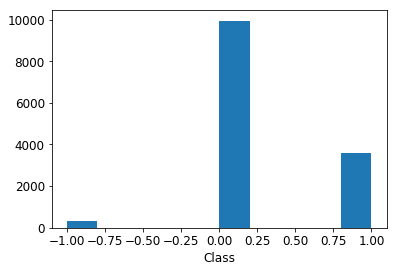

In [9]:
h = plt.hist(label, histtype='bar')
plt.xlabel('Class')

Next, I would like to tidy things up a bit. Thus this routine loads the table, classifies the galaxies _and throws out the unclassified galaxies_.

In [10]:
def prepare_data():
    """
    Load the table of galaxies and keep only ellipticals and spirals. 
    """

    t = read_morphology_catalogue()
    # Use default settings
    label = create_label(t)

    # Extract only ellipticals and spirals
    use = np.where((label >= 0) & (t['GR_REST'] > -1) & 
                   (t['GR_REST'] < 3.5) & (np.isfinite(t['GR_REST'])))
    t = t[use]
    label = label[use]

    return t, label
    

In [11]:
t, label = prepare_data()

/Users/jarle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/jarle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


To illustrate the data - and what we will do below, it is perhaps useful to see a poorly documented function that creates a plot more or less like the one I showed in the lecture:

In [12]:
def show_colour_class(t, N=500, include_kde=True):
    """
Show a plot illustrating the classes and their colours. This creates
a plot with two panels. The top panel will show a histogram of the g-r
colours and the bottom will show the actual points.

If include_kde is set to true then a KDE estimate is plotted on top
of the histograms.
    """


    ax_top = plt.subplot(211)
    ax_bottom = plt.subplot(212, sharex=ax_top)
    plt.setp( ax_top.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    # Find all spirals and ellipticals.
    is_e, = np.where((t['T_TYPE'] >= -10) & (t['T_TYPE'] <= -4))
    is_s, = np.where((t['T_TYPE'] >= 4) & (t['T_TYPE'] <= 10))

    # Get the first N.
    is_e = is_e[0:N]
    is_s = is_s[0:N]

    gr_s = t['GR_REST'][is_s]
    gr_e = t['GR_REST'][is_e]
    y = np.arange(N)
 
    # Now plot the scatter plot.
    ax_bottom.scatter(gr_s, y, c='b')
    ax_bottom.scatter(gr_e, y, c='r')
    ax_bottom.set_xlim(0, 1.1)


    # Then the histogram
    hist(gr_s, bins=50, range=(0, 1.2), ax=ax_top, 
         histtype='step', color='b', normed=True)
    hist(gr_e, bins=50, range=(0, 1.2), ax=ax_top, 
         histtype='step', color='r', normed=True)

    # Finally create the kernel density estimate
    kde_s = KernelDensity(0.025, kernel='gaussian').fit(gr_s[:, np.newaxis])
    kde_e = KernelDensity(0.025, kernel='gaussian').fit(gr_e[:, np.newaxis])

    gr_plot = np.linspace(0, 1.2, 1000)
    ln_h_s = kde_s.score_samples(gr_plot[:,np.newaxis])
    ln_h_e = kde_e.score_samples(gr_plot[:,np.newaxis])
    h_s = np.exp(ln_h_s)
    h_e = np.exp(ln_h_e)
    
    ax_top.plot(gr_plot, h_s, color='#000099')
    ax_top.plot(gr_plot, h_e, color='#990000')
    ax_bottom.set_ylim([-50, 590])

    plt.show()


        Use astropy.visualization.hist instead. [__main__]
/Users/jarle/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
        Use astropy.visualization.hist instead. [__main__]


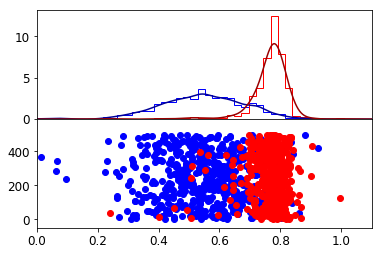

In [13]:
show_colour_class(t)

## Classification

We are now ready to carry out the classification of the data. This is achieved by the following function:

In [14]:
def derive_p_class(t, label=None, ellipticals=(-10, 4), spirals=(4, 10),\
                    bw_spiral=0.025, bw_elliptical=0.025):
    """
 Given the table and a set of indices of the training sample, 
 calculate the likelihood distribution p(g-r|class)

    Input:
    ------
    t: A table such as that returned by the read_morphology_catalogue routine
 label: The class label of each galaxy in t. If None, this is derived by calling create_label.
 ellipticals: See create_label
 spirals:     See create_label

 bw_spiral: The band-width of the kernel used to estimate p(g-r|class) for spirals.
 bw_elliptical: The band-width for p(g-r|class) for ellipticals.
 
    Output:
    -------
    
    The kernel density for p(g-r|spiral) and p(g-r|elliptical). These are created 
    using KernelDensity in sklearn and the can be called as we have done in the past.
    """

    # Classify galaxies if needed.
    if label is None:
        label = create_label(t, ellipticals=ellipticals, spirals=spirals)

    # Get the feature(s) for the sample
    gr = t['GR_REST']

    # Then find the spirals and ellipticals.
    is_s = np.where(label == 1)
    is_e = np.where(label == 0)

    # Get the colours of the spirals and ellipticals.
    gr_s = gr[is_s]
    gr_e = gr[is_e]
    
    # Create the kernel density estimates
    kde_s = KernelDensity(bw_spiral, kernel='gaussian').fit(gr_s[:, np.newaxis])
    kde_e = KernelDensity(bw_elliptical, kernel='gaussian').fit(gr_e[:, np.newaxis])

    return kde_s, kde_e


In [15]:
kde_s, kde_e = derive_p_class(t, label)

## Creating a test and training sample.

The final utility that is worth showing you before you get on with your problem is to show how one can easily create a test and training sample. To do this here I chose to create an index array with the length of the full table and then call the `train_test_split` function on this to create an index array for the training and test samples (see the documentation for `train_test_split` to see what you are actually doing here!). There are of course other ways to do this. 

The result here is that the `train` and `test` variables will each contain a table like `t`.

In [16]:
inds = np.arange(len(t))
i_train, i_test = train_test_split(inds)
train = t[i_train]
test = t[i_test]

# Your tasks

Ok, that is enough for starting out. Now try to use the above to do the following:

 1. Classify the sample of galaxies and calculate the mis-classification rate for spirals and ellipticals (see the lecture notes for the definition of mis-classification rate).
 2. Does the mis-classification rate depend on the band-width? Could you use this to determine the band-width?
 3. Classify the galaxies using a Gaussian Mixture Model instead. *Hint: you might want to modify the `derive_p_class` function.*